# **Binary Classification - Waste Classification**

---

## **Introduction**

In this notebook, I will be using a dataset that contains images of waste. The dataset is divided into two categories: organic and recyclable. Organic waste includes materials such as food waste and biodegradable waste. Recyclable waste includes materials such as paper, plastic, metal, and glass.

The dataset is already divided into a training and test set. The training set contains 22564 images and the test set contains 2513 images. The images are of different sizes and shapes. The dataset is available at the following link: [Waste Classification Dataset](https://www.kaggle.com/datasets/techsash/waste-classification-data/data)

**The goal of this notebook will be to create a binary classification model that can classify waste into two categories: organic and recyclable.**


## **Table of Contents**

1. [Importing data and libraries](#1.-Importing-data-and-libraries)
2. [Data Exploration](#2.-Data-Exploration)
3. [Data Visualization](#3.-Data-Visualization)
4. [Data Preprocessing](#4.-Data-Preprocessing)
5. [Creating the Models](#5.-Creating-the-Models)  
   5.1 [Logistic Regression](#5.1-Logistic-Regression)  
   5.2 [Random Forest](#5.2-Random-Forest)  
   5.3 [Support Vector Machine](#5.3-Support-Vector-Machine)
6. [Conclusion](#6.-Conclusion)


## **1. Importing data and libraries**

---


In [26]:
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os

for dirname, _, _ in os.walk('data/waste_classification'):
    print(dirname)

train_path = 'data/waste_classification/DATASET/TRAIN'
test_path = 'data/waste_classification/DATASET/TEST'

data/waste_classification
data/waste_classification\DATASET
data/waste_classification\DATASET\DATASET
data/waste_classification\DATASET\DATASET\TEST
data/waste_classification\DATASET\DATASET\TEST\O
data/waste_classification\DATASET\DATASET\TEST\R
data/waste_classification\DATASET\DATASET\TRAIN
data/waste_classification\DATASET\DATASET\TRAIN\O
data/waste_classification\DATASET\DATASET\TRAIN\R
data/waste_classification\DATASET\TEST
data/waste_classification\DATASET\TEST\O
data/waste_classification\DATASET\TEST\R
data/waste_classification\DATASET\TRAIN
data/waste_classification\DATASET\TRAIN\O
data/waste_classification\DATASET\TRAIN\R


## **2. Data Exploration**

[Back to top](#Table-of-Contents)

---


In [27]:
# List comprehension to get the number of files in each folder.
total_train = sum([len(files) for _, _, files in os.walk(train_path)])
total_test = sum([len(files) for _, _, files in os.walk(test_path)])

print(f'Total training images: {total_train}')
print(f'Total testing images: {total_test}')

Total training images: 22564
Total testing images: 2513


We can see that we have 22564 images in the training set and 2513 images in the test set. The images are also divided into two categories: organic and recyclable.


In [28]:
organic = len(os.listdir(train_path + '/O'))
recyclable = len(os.listdir(train_path + '/R'))

print('Train set organic images:', organic)
print('Train set recyclable images:', recyclable)

organic = len(os.listdir(test_path + '/O'))
recyclable = len(os.listdir(test_path + '/R'))

print('Test set organic images:', organic)
print('Test set recyclable images:', recyclable)

Train set organic images: 12565
Train set recyclable images: 9999
Test set organic images: 1401
Test set recyclable images: 1112


There are 12565 images of organic waste and 9999 images of recyclable waste in the training set. In the test set, there are 1401 images of organic waste and 1112 images of recyclable waste.


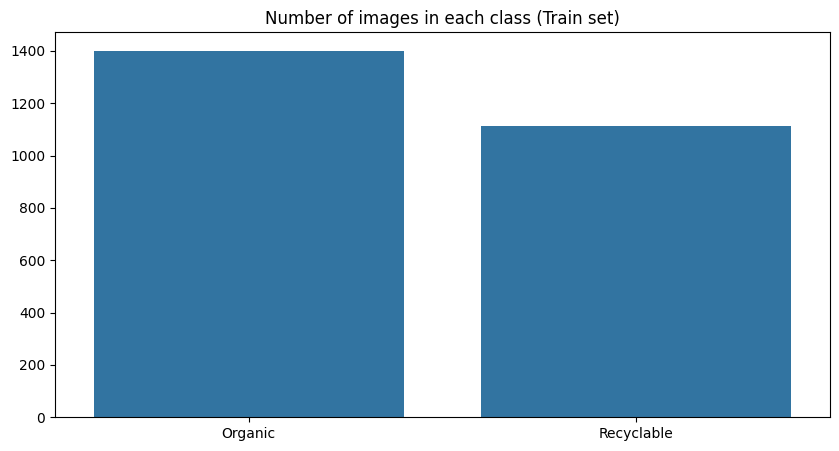

In [29]:
plt.figure(figsize=(10, 5))
sns.barplot(x=['Organic', 'Recyclable'], y=[organic, recyclable])
plt.title('Number of images in each class (Train set)')
plt.show()

## **3. Data Visualization**

[Back to top](#Table-of-Contents)

---

Now let's visualize some of the images in the training set to get a better understanding of the data.


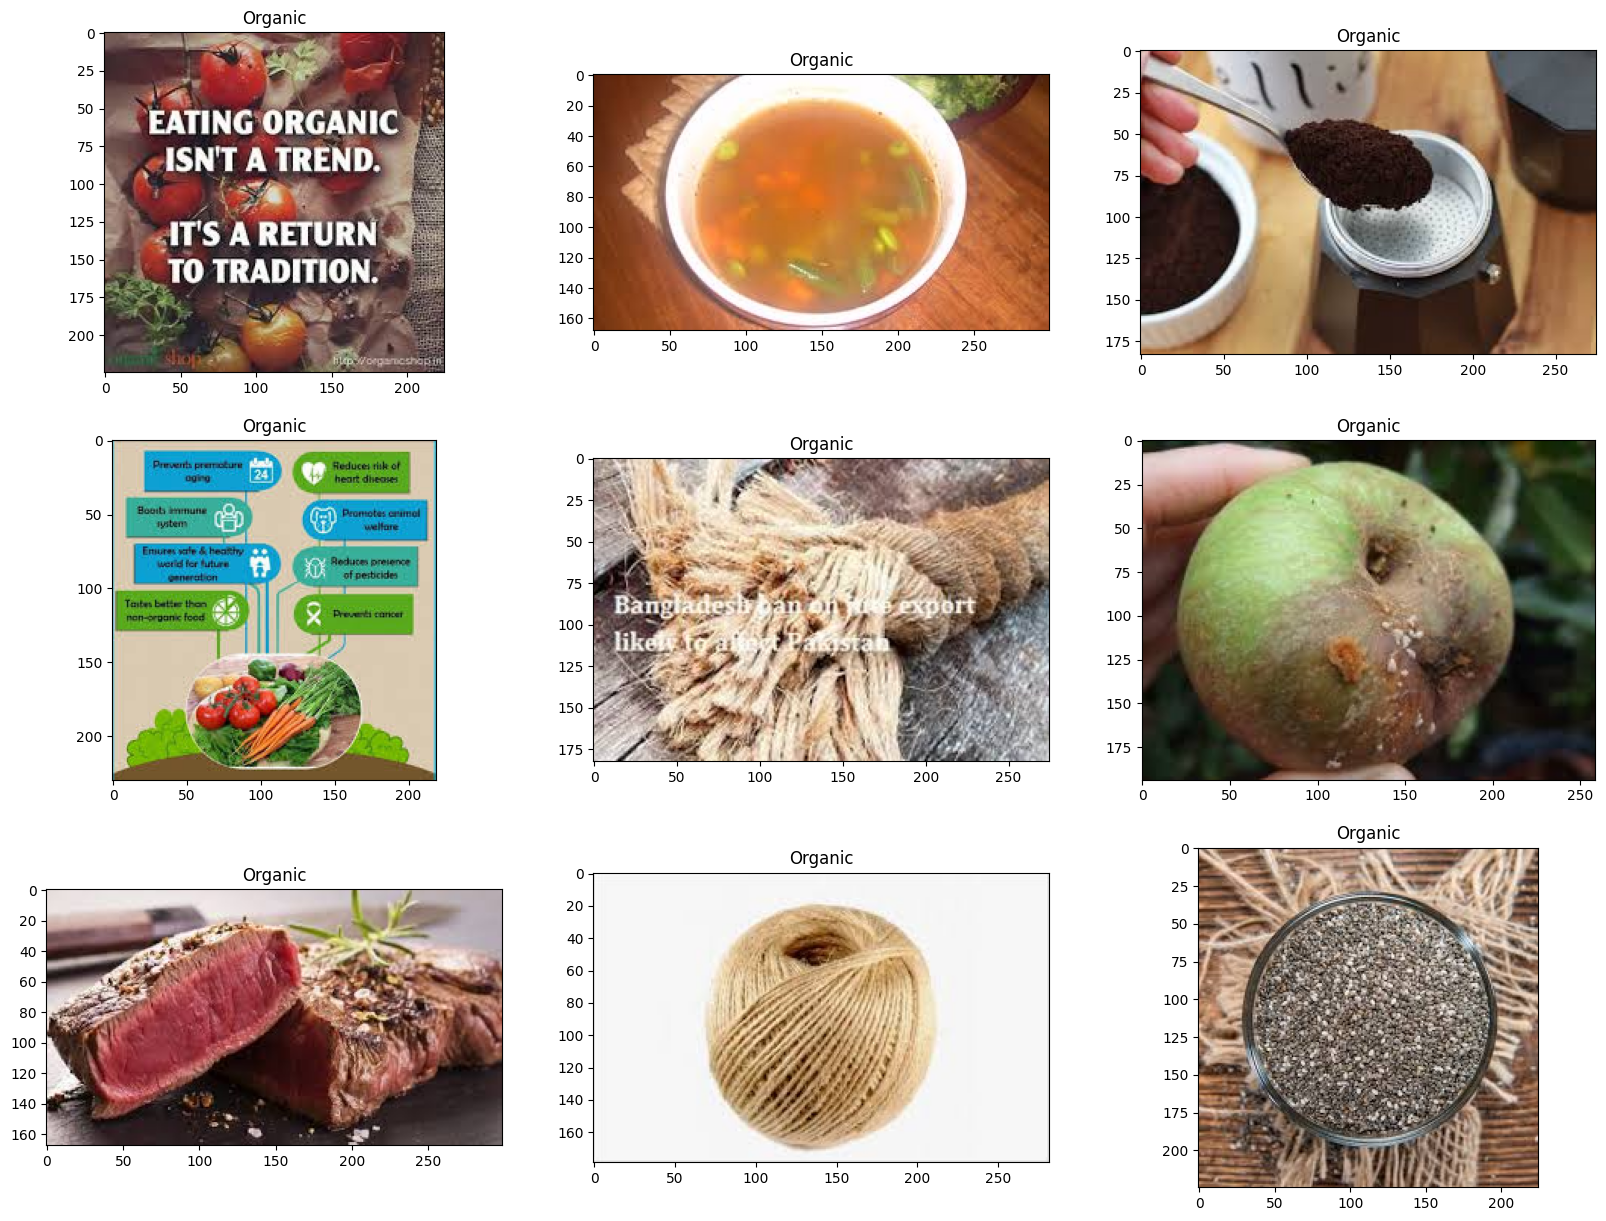

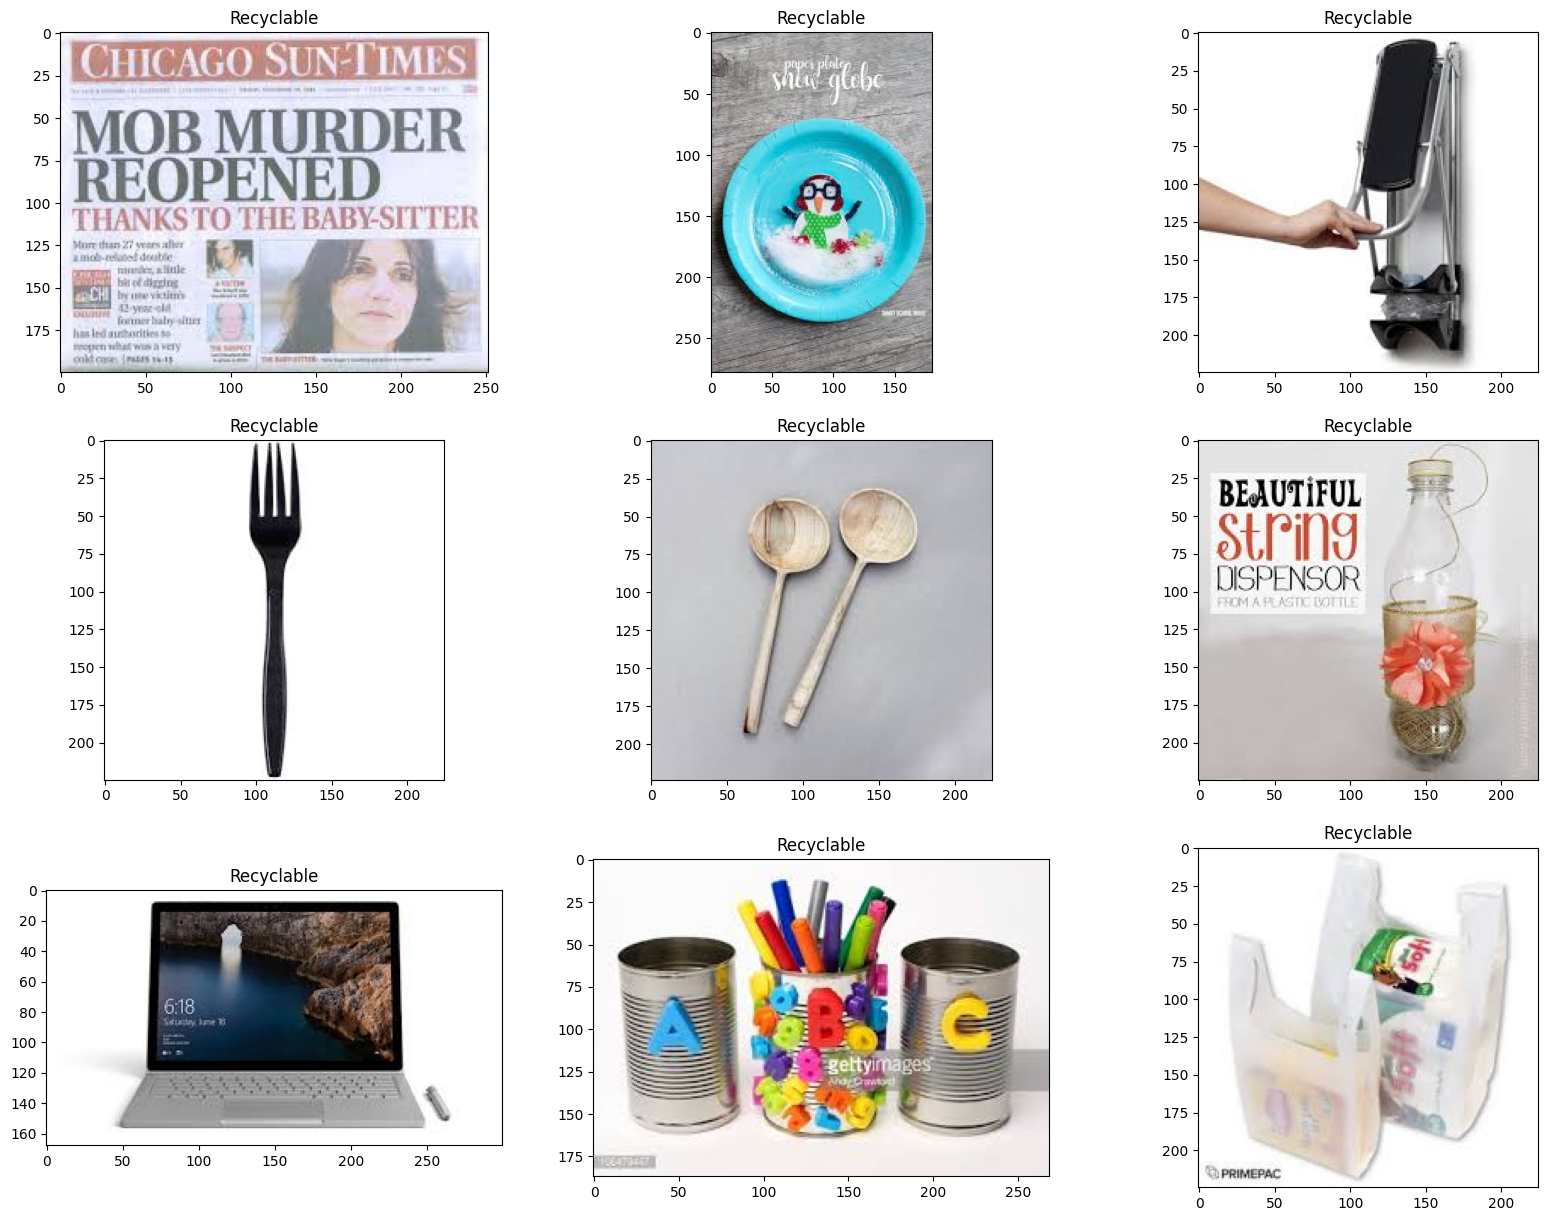

In [30]:
def show_images(path, label):
    plt.figure(figsize=(20, 15))
    for i in range(1, 10):
        plt.subplot(3, 3, i)
        idx = np.random.randint(0, len(os.listdir(path)))
        img = cv2.imread(path + '/' + os.listdir(path)[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title(label)
    plt.show()
    
show_images(train_path + '/O', 'Organic')
show_images(train_path + '/R', 'Recyclable')

As we can see, the images are of different sizes and shapes. We will need to resize the images to a standard size before we can use them to train a model.


## **4. Data Preprocessing**

[Back to top](#Table-of-Contents)

---

Before we can use the images to train a model, we need to preprocess the data. This involves resizing the images to a standard size and converting them to arrays.

**I will only be using a subset of the training set to train the models. I will be using 1000 images of organic waste and 1000 images of recyclable waste. (Still took 30 minutes to run)**


In [31]:
def load_images(path, label, amount=1000):
    data = []
    labels = []
    for img in tqdm(os.listdir(path)[:amount]): # Slice the list to load a certain amount of images.
        img = cv2.imread(path + '/' + img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224))
        data.append(img)
        labels.append(label)
    return data, labels

train_organic, train_organic_labels = load_images(train_path + '/O', 0)
train_recyclable, train_recyclable_labels = load_images(train_path + '/R', 1)
test_organic, test_organic_labels = load_images(test_path + '/O', 0)
test_recyclable, test_recyclable_labels = load_images(test_path + '/R', 1)

X_train = np.array(train_organic + train_recyclable)
y_train = np.array(train_organic_labels + train_recyclable_labels)

X_test = np.array(test_organic + test_recyclable)
y_test = np.array(test_organic_labels + test_recyclable_labels)

print('Train set:', X_train.shape, y_train.shape)
print('Test set:', X_test.shape, y_test.shape)

100%|██████████| 1000/1000 [00:00<00:00, 1235.30it/s]


Train set: (2000, 224, 224, 3) (2000,)
Test set: (2000, 224, 224, 3) (2000,)


The function load_images takes the path to a directory and a label as input. It then loads the images from the directory, resizes them to 224x224, and appends them to a list. It also appends the label to a separate list. The function returns the list of images and the list of labels.


In [32]:
X_train = X_train / 255.0
X_test = X_test / 255.0

X_train = X_train.reshape(-1, 224 * 224 * 3)
X_test = X_test.reshape(-1, 224 * 224 * 3)

print('Train set:', X_train.shape, y_train.shape)
print('Test set:', X_test.shape, y_test.shape)

Train set: (2000, 150528) (2000,)
Test set: (2000, 150528) (2000,)


Then we normalize the pixel values by dividing them by 255.0. We also reshape the images to a single dimension. This is because the models we will be using require the input to be a single dimension. The steps left before we can train a model are to split the training set into a training and validation set and to encode the labels.


In [33]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

## **5. Creating the models**

[Back to top](#Table-of-Contents)

---

Now that the data is preprocessed, I will create three sklearn models to classify the waste images:

- Logistic Regression
- Random Forest
- Support Vector Machine

I predict that the Random Forest model will perform the best, because it is an ensemble method that is robust to overfitting and can handle non-linear relationships between the features and the target variable. I will evaluate the models using the accuracy score, confusion matrix, and cross-validation score.


#### **5.1 Logistic Regression**


In [34]:
def copy_data():
    """Returns a copy of the data. To avoid modifying the original data."""
    return X_train.copy(), y_train.copy(), X_test.copy(), y_test.copy()

X_train_copy, y_train_copy, X_test_copy, y_test_copy = copy_data()

model = LogisticRegression(max_iter=1000)

model.fit(X_train_copy, y_train_copy)
y_pred = model.predict(X_test_copy)

print('Accuracy:', accuracy_score(y_test_copy, y_pred))

Accuracy: 0.7895


The accuracy of the logistic regression model is 78.9%. This is a good result, but we can probably do better with a different model.


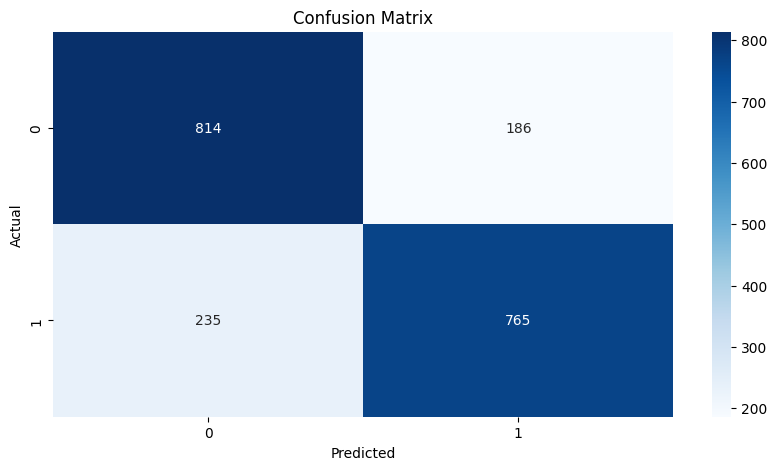

In [35]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(y_test_copy, y_pred)

> Confusion Matrix order:
>
> - True Negative (TN)
> - False Positive (FP)
> - False Negative (FN)
> - True Positive (TP)

The confusion matrix shows 186 false positives and 235 false negatives. This means that the model is misclassifying organic waste as recyclable waste and recyclable waste as organic waste. The distribution of this misclassification is fairly balanced, with slightly more false positives than false negatives. Which is good because it means that the model is not biased towards one class.


In [36]:
cv = KFold(n_splits=5, random_state=42, shuffle=True)
scores = cross_val_score(model, X_train_copy, y_train_copy, cv=cv)
print('Cross-validation scores:', scores)
print('Mean cross-validation score:', scores.mean())

Cross-validation scores: [0.8    0.8075 0.77   0.795  0.795 ]
Mean cross-validation score: 0.7935


The mean cross-validation score is 79.4%, which is close to the accuracy of the model. This means that the model is not overfitting the training data.


#### **5.2 Random Forest**


In [37]:
X_train_copy, y_train_copy, X_test_copy, y_test_copy = copy_data()

model = RandomForestClassifier(n_estimators=100, random_state=42)

model.fit(X_train_copy, y_train_copy)
y_pred = model.predict(X_test_copy)

print('Accuracy:', accuracy_score(y_test_copy, y_pred))

Accuracy: 0.8545


The accuracy of the random forest model is 85.4%. Which is higher than the accuracy of the logistic regression model. This is what I expected, because the random forest model is an ensemble method that is robust to overfitting and can handle non-linear relationships between the features and the target variable.

> Ensemble methods are machine learning algorithms that rely on the "wisdom of the crowd". They combine the predictions of multiple models to improve the accuracy of the predictions.


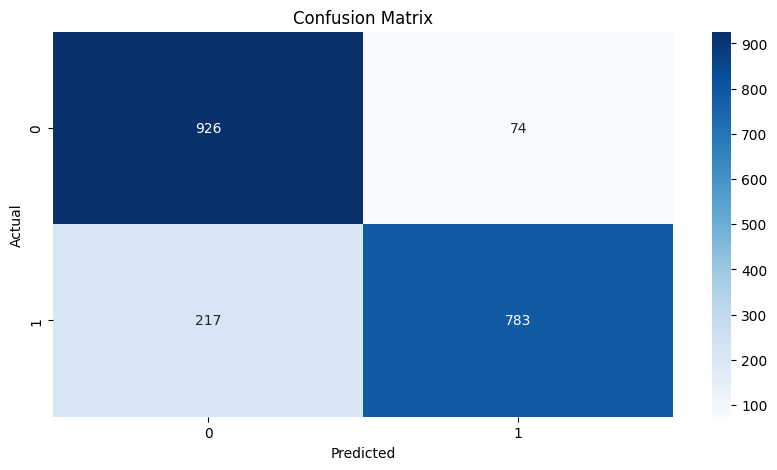

In [38]:
plot_confusion_matrix(y_test_copy, y_pred)

The confusion matrix shows 74 false positives and 217 false negatives. When compared to the logistic regression model, the random forest model has fewer false positives and more false negatives. This means that the random forest model is better at classifying organic waste, but worse at classifying recyclable waste.


In [39]:
cv = KFold(n_splits=5, random_state=42, shuffle=True)
scores = cross_val_score(model, X_train_copy, y_train_copy, cv=cv)
print('Cross-validation scores:', scores)
print('Mean cross-validation score:', scores.mean())

Cross-validation scores: [0.83   0.84   0.8275 0.7925 0.8375]
Mean cross-validation score: 0.8255000000000001


The mean cross-validation score is 82.6%, which is close to the accuracy of the model. This means that the model is unlikely to be overfitting the training data.


#### **5.3 Support Vector Machine**


In [40]:
X_train_copy, y_train_copy, X_test_copy, y_test_copy = copy_data()

model = SVC()

model.fit(X_train_copy, y_train_copy)
y_pred = model.predict(X_test_copy)

print('Accuracy:', accuracy_score(y_test_copy, y_pred))

Accuracy: 0.8665


The accuracy of the support vector machine model is 86.7%. This is the highest accuracy of the three models.

I'm guessing that the support vector machine model is performing the best because it is effective for binary image classification due to its ability to find the optimal hyperplane that best separates different classes in high-dimensional feature spaces. This is crucial for distinguishing between different types of waste materials based on visual features. In contrast, Random Forests may struggle with binary image classification in this context due to their decision tree-based approach, which might not effectively capture the complex relationships between features in images without extensive feature engineering or pre-processing.


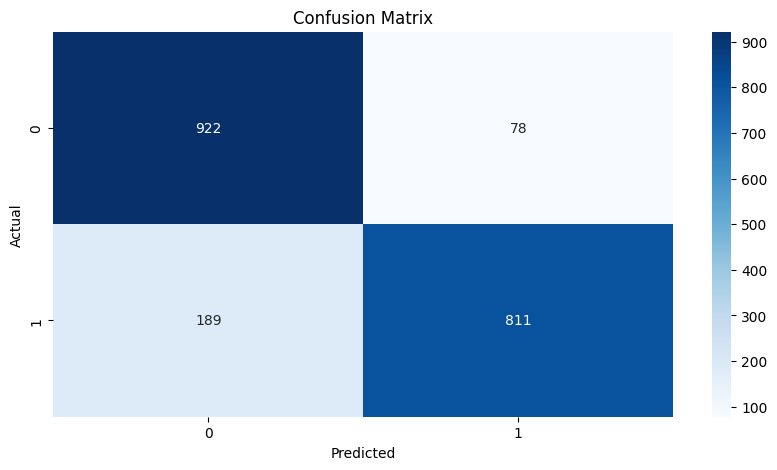

In [41]:
plot_confusion_matrix(y_test_copy, y_pred)

The confusion matrix shows to be slightly better than the Random Forest model, with 78 false positives and 189 false negatives. It also looks to be less biased towards one class, with slightly more false negatives than false positives.


In [42]:
cv = KFold(n_splits=5, random_state=42, shuffle=True)
scores = cross_val_score(model, X_train_copy, y_train_copy, cv=cv)
print('Cross-validation scores:', scores)
print('Mean cross-validation score:', scores.mean())

Cross-validation scores: [0.8225 0.85   0.8425 0.8225 0.8525]
Mean cross-validation score: 0.8379999999999999


The mean cross-validation score is 83.8%, which is close to the accuracy of the model. This means that the model is not overfitting the training data. The mean cross-validation score is also higher than the accuracy of the logistic regression model, which means that the model is performing better than the logistic regression model.


## **6. Conclusion**

[Back to top](#Table-of-Contents)

---

In this notebook, I created three models to classify waste images into two categories: organic and recyclable. The models I created were logistic regression, random forest, and support vector machine. The support vector machine model performed the best, with an accuracy of 86.7%. This is a good result, but there is still room for improvement. I could try using a different model, such as a convolutional neural network, to see if I can improve the accuracy of the classification. I could also try using a larger subset of the training set to train the models, to see if more data improves the accuracy of the classification.

My prediction was incorrect, as the Support Vector Machine model performed the best. Though the difference in accuracy between the models is not that big, so it is possible that the Random Forest model could perform better with some hyperparameter tuning. I was expecting the Random Forest model to perform the best, because it is an ensemble method that is robust to overfitting and can handle non-linear relationships between the features and the target variable. However, the Support Vector Machine model performed the best, with an accuracy of 86.7%. This is likely because the support vector machine model is effective for binary image classification due to its ability to find the optimal hyperplane that best separates different classes in high-dimensional feature spaces. This is crucial for distinguishing between different types of waste materials based on visual features. In contrast, Random Forests may struggle with binary image classification in this context due to their decision tree-based approach, which might not effectively capture the complex relationships between features in images without extensive feature engineering or pre-processing.
